# LineageOT benchmark

In [1]:
# pip install git+https://github.com/aforr/LineageOT@master cvxopt

In [2]:
from jax.config import config
config.update("jax_enable_x64", True)

from ott.geometry.geometry import Geometry
from ott.geometry.pointcloud import PointCloud
from jax import numpy as jnp
import seaborn as sns

from time import perf_counter
from moscot import FusedGW, Regularized, GW
import pickle
import os
import networkx as nx
from tqdm.auto import tqdm

In [3]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ot

import lineageot.simulation as sim
import lineageot.evaluation as sim_eval
import lineageot.inference as sim_inf

from typing import Literal, Optional, Sequence, Dict
import traceback
from collections import namedtuple, defaultdict
from copy import deepcopy

In [4]:
bnt = namedtuple("bnt", "tmat early_cost late_cost norm_diff converged time")
stn = namedtuple("sim",
                 "ancestor_info "
                 "rna_arrays "
                 "true_coupling "
                 "true_distances "
                 "barcode_arrays "
                 "fitted_distances "
                 "ec_scale lc_scale "
                 "early_time_rna_cost "
                 "late_time_rna_cost")

In [5]:
def lot_annotate(fitted_tree: nx.DiGraph, barcodes: np.ndarray, time: float, rate_estimate=None):
    sim_inf.add_leaf_barcodes(fitted_tree, barcodes)
    sim_inf.add_leaf_times(fitted_tree, time)

    # Estimating a uniform mutation rate for all target sites
    if rate_estimate is None:
        rate_estimate = sim_inf.rate_estimator(barcodes, time)
    sim_inf.annotate_tree(fitted_tree, 
                          rate_estimate*np.ones(barcodes.shape[1]),
                          time_inference_method = 'least_squares')
    
    
# root is included twice in LOT code, causes errors with NetworkX
def _internal_nodes_fixed(tree):
    """
    Returns a list of the non-leaf nodes of a tree
    """
    import inspect
    
    curframe = inspect.currentframe()
    calframe = inspect.getouterframes(curframe, 2)
    caller = calframe[1][3]
    
    nodes = [node for node in tree if tree.degree(node) >= 2]
    nodes.sort(key=lambda n: "zzzzzzz" if n == 'root' else str(n))
    if caller == 'add_times':
        nodes = [n for n in nodes if n != "root"]
                
    return nodes


# monkeypatched because our tree has 'root' somehow inside and it's problematic with the sort
# uncomment for estim='lot'
# sim_inf.get_internal_nodes = _internal_nodes_fixed


def cassiopeia_distances(barcodes, solver='hybrid', estim='mle',
                         time: float = 1.0,
                         rate_estimate=None,
                         bayesian_estimator_kwargs={},
                         only_tree=False,
                         hybrid_solver_kwargs={}, **kwargs):
    import cassiopeia as cas
    # pip install gurobipy  # for hybrid solver
    # if too big a problem, it raises:
    # GurobiError: Model too large for size-limited license; visit https://www.gurobi.com/free-trial for a full license
    
    n = barcodes.shape[0]
    barcodes = pd.DataFrame(barcodes, index=map(str, range(n)))
    tree = cas.data.CassiopeiaTree(character_matrix=barcodes)
    
    # for ILPSolver
    kwargs.setdefault("convergence_time_limit", 600)  # 10mins
    kwargs.setdefault("maximum_potential_graph_layer_size", 10000)
    
    if estim == 'bayesian':
        print("Setting solver to neighbor joining")
        solver = 'nj'
    
    if solver == 'nj':
        solver = cas.solver.NeighborJoiningSolver(add_root=True)
    elif solver == 'greedy':
        solver = cas.solver.VanillaGreedySolver()
    elif solver == 'ilp':
        solver = cas.solver.ILPSolver(weighted=False, seed=1234, **kwargs)
    elif solver == 'hybrid':
        ts = cas.solver.VanillaGreedySolver()
        bs = cas.solver.ILPSolver(weighted=False, seed=1234, **kwargs)
        solver = cas.solver.HybridSolver(top_solver=ts, bottom_solver=bs, **hybrid_solver_kwargs)
    else:
        raise NotImplementedError(solver)
        
    solver.solve(tree, collapse_mutationless_edges=estim != 'bayesian')
    if only_tree:
        G = deepcopy(tree._CassiopeiaTree__network)
        G = nx.relabel_nodes(G, dict(zip(map(str, range(n)), range(n))))
        root = [n for n in G.nodes if G.in_degree(n) == 0]
        assert len(root) == 1
        root = root[0]
        G = nx.relabel_nodes(G, {root: "root"})
        return tree, G, None
    
    if estim == 'mle':
        estim = cas.tools.branch_length_estimator.IIDExponentialMLE()
        estim.estimate_branch_lengths(tree)
    elif estim == 'bayesian':
        # root must have 1 child
        # otherwise, must be a full binary tree
        root = tree.root
        tree._CassiopeiaTree__add_node("synroot")
        tree._CassiopeiaTree__add_edge("synroot", root)
        tree._CassiopeiaTree__cache['root'] = 'synroot'
        tree.reconstruct_ancestral_characters()
        # tree.set_character_states("synroot", [])
        # tree._CassiopeiaTree__network.nodes["synroot"]['character_states'] = []
        estim = cas.tools.branch_length_estimator.IIDExponentialBayesian(**bayesian_estimator_kwargs)
        estim.estimate_branch_lengths(tree)
        tree._CassiopeiaTree__remove_node("synroot")
        tree._CassiopeiaTree__cache['root'] = root
    elif estim == 'lot':
        pass
    else:
        raise NotImplementedError(estim)
        
    G = deepcopy(tree._CassiopeiaTree__network)
    G = nx.relabel_nodes(G, dict(zip(map(str, range(n)), range(n))))
    root = [n for n in G.nodes if G.in_degree(n) == 0]
    assert len(root) == 1
    root = root[0]
    G = nx.relabel_nodes(G, {root: "root"})
    if estim == 'lot':
        lot_annotate(G, barcodes.values, time=time, rate_estimate=rate_estimate)
        return tree, G, sim_inf.compute_tree_distances(G)
    
    sim_inf.add_division_times_from_vertex_times(G, current_node='root')
    G = sim_inf.add_times_to_edges(G)
    # G = sim_inf.add_inverse_times_to_edges(G)
    
    return tree, G, sim_inf.compute_tree_distances(G)

In [6]:
def create_geometry(cost_matrix: np.ndarray, scale='max') -> Geometry:
    cost_matrix = jnp.array(cost_matrix)
    if scale is None:
        pass
    elif scale == 'max':
        cost_matrix /= cost_matrix.max()
        assert cost_matrix.max() == 1.0
    elif scale == 'mean':
        cost_matrix /= np.mean(cost_matrix)
    elif scale == 'median':
        cost_matrix /= np.median(cost_matrix)
    else:
        raise NotImplementedError(scale)
        
    assert (cost_matrix >= 0).all()
    return Geometry(cost_matrix=cost_matrix)


def fgw_solver(C1, C2, C12, alpha=0, epsilon=1e-2, loss_fun='square_loss',
              p=None, q=None, max_iterations=100, rtol=1e-9, atol=1e-9, verbose=False):
    
    from ot.gromov import init_matrix, gwggrad, gwloss
    
    assert 0 <= alpha <= 1, alpha
    
    if p is None:
        p = np.ones((C1.shape[0],), dtype=np.float64) / C1.shape[0]
    if q is None:
        q = np.ones((C2.shape[0],), dtype=np.float64) / C2.shape[0]

    solver = ot.sinkhorn if epsilon >= 0.1 else ot.bregman.sinkhorn_epsilon_scaling
    C1 = np.asarray(C1, dtype=np.float64)
    C2 = np.asarray(C2, dtype=np.float64)
    
    if alpha == 0:
        C12 = np.asarray(C12, dtype=np.float64)
        return solver(p, q, C12, reg=epsilon, numItermax=max_iterations, stopThr=rtol)
    if alpha == 1:
        return ot.gromov.entropic_gromov_wasserstein(C1, C2, p=p, q=q, loss_fun=loss_fun, epsilon=epsilon, tol=rtol)

    C12 = np.asarray(C12, dtype=np.float64)
    C12 = (1 - alpha) * C12
    f_val = 0
    T = np.outer(p, q)
    constC, hC1, hC2 = init_matrix(C1, C2, p, q, loss_fun)
    
    
    fmt = "{:5s}|{:12s}|{:8s}|{:8s}"
    if verbose:
        print(
            fmt.format(
                "It.",
                "Loss",
                "Rel. loss   ",
                "Abs. loss   ",
            )
            + "\n"
            + "-" * 83
        )
    
    for i in range(max_iterations):
        old_fval = f_val

        # compute the gradient
        tens = C12 + alpha * gwggrad(constC, hC1, hC2, T)
        T = solver(p, q, tens, reg=epsilon)
        
        f_val = gwloss(constC, hC1, hC2, T)
        abs_delta_fval = abs(f_val - old_fval)
        relative_delta_fval = abs_delta_fval / abs(f_val)
        
        if verbose:
            print(
                f"{i + 1:5d}|{f_val:8e}|{relative_delta_fval:8e}|{abs_delta_fval:8e}"
            )
        
        if relative_delta_fval <= rtol or abs_delta_fval <= atol:
            break
    
    return T

In [7]:
def init_sim(flow_type: Literal['bifurcation', 'convergent', 'partial_convergent', 'mistmatched_clusters'],
             seed: int = 257, plot: bool = True, **kwargs):
    fpath = f"{flow_type}_sim.pickle"
    if os.path.isfile(fpath):
        try:
            with open(fpath, "rb") as fin:
                return stn(*pickle.load(fin))
        except Exception:
            pass
    
    start = perf_counter()
    np.random.seed(seed) 
    if flow_type == 'bifurcation':
        timescale = 1
    else:
        timescale = 100

    x0_speed = 1/timescale
    sim_params = sim.SimulationParameters(division_time_std = 0.01*timescale,
                                          flow_type = flow_type,
                                          x0_speed = x0_speed,
                                          mutation_rate = 1/timescale,
                                          mean_division_time = 1.1*timescale,
                                          timestep = 0.001*timescale,
                                          **kwargs)

    # These parameters can be adjusted freely.
    # As is, they replicate the plots in the paper for the fully convergent simulation.
    mean_x0_early = 2
    time_early = 7.4*timescale # Time when early cells are sampled
    time_late = time_early + 4*timescale # Time when late cells are sampled
    x0_initial = mean_x0_early -time_early*x0_speed
    initial_cell = sim.Cell(np.array([x0_initial, 0, 0]), np.zeros(sim_params.barcode_length))
    sample_times = {'early' : time_early, 'late' : time_late}



    # Choosing which of the three dimensions to show in later plots
    if flow_type == 'mismatched_clusters':
        dimensions_to_plot = [1, 2]
    else:
        dimensions_to_plot = [0, 1]

    ## Running the simulation
    sample = sim.sample_descendants(initial_cell.deepcopy(), time_late, sim_params)

    # Extracting trees and barcode matrices
    true_trees = {'late': sim_inf.list_tree_to_digraph(sample)}
    true_trees['late'].nodes['root']['cell'] = initial_cell
    true_trees['early'] = sim_inf.truncate_tree(true_trees['late'], sample_times['early'], sim_params)

    # Computing the ground-truth coupling
    true_coupling = sim_inf.get_true_coupling(true_trees['early'], true_trees['late'])
    
    data_arrays = {'late': sim_inf.extract_data_arrays(true_trees['late']),
                   'early': sim_inf.extract_data_arrays(true_trees['early'])}
    rna_arrays = {'late': data_arrays['late'][0]}
    barcode_arrays = {'early': data_arrays['early'][1], 'late': data_arrays['late'][1]}

    rna_arrays['early'] = sim_inf.extract_data_arrays(true_trees['early'])[0]
    num_cells = {'early': rna_arrays['early'].shape[0], 'late': rna_arrays['late'].shape[0]}

    print("Times:", sample_times)
    print("Number of cells:", num_cells)
    
        # Creating a copy of the true tree for use in LineageOT
    true_trees['late, annotated'] = copy.deepcopy(true_trees['late'])
    sim_inf.add_node_times_from_division_times(true_trees['late, annotated'])

    sim_inf.add_nodes_at_time(true_trees['late, annotated'], sample_times['early'])
    
    if plot:
        # Scatter plot of cell states
        cmap = "coolwarm"
        colors = [plt.get_cmap(cmap)(0), plt.get_cmap(cmap)(256)]
        for a,label, c in zip([rna_arrays['early'], rna_arrays['late']], ['Early cells', 'Late cells'], colors):
            plt.scatter(a[:, dimensions_to_plot[0]],
                        a[:, dimensions_to_plot[1]], alpha = 0.4, label = label, color = c)

        plt.xlabel('Gene ' + str(dimensions_to_plot[0] + 1))
        plt.ylabel('Gene ' + str(dimensions_to_plot[1] + 1))
        plt.legend()
        
    # Infer ancestor locations for the late cells based on the true lineage tree
    observed_nodes = [n for n in sim_inf.get_leaves(true_trees['late, annotated'], include_root=False)]
    sim_inf.add_conditional_means_and_variances(true_trees['late, annotated'], observed_nodes)

    ancestor_info = {'true tree': sim_inf.get_ancestor_data(true_trees['late, annotated'], sample_times['early'])}
    
    # True distances
    true_distances = {key: sim_inf.compute_tree_distances(true_trees[key]) for key in true_trees}
    
    rate_estimate = sim_inf.rate_estimator(barcode_arrays['late'], sample_times['late'])

    print("Fraction unmutated barcodes: ", {key:np.sum(barcode_arrays[key] == 0)/barcode_arrays[key].size
                                            for key in barcode_arrays})
    print("Rate estimate: ", rate_estimate)
    print("True rate: ", sim_params.mutation_rate / sim_params.barcode_length)
    print("Rate accuracy: ", rate_estimate*sim_params.barcode_length/sim_params.mutation_rate)
    
    # Compute Hamming distance matrices for neighbor joining

    hamming_distances_with_roots = {
        'early': sim_inf.barcode_distances(np.concatenate([barcode_arrays['early'],
                                                           np.zeros([1,sim_params.barcode_length])])),
        'late': sim_inf.barcode_distances(np.concatenate([barcode_arrays['late'],
                                                          np.zeros([1,sim_params.barcode_length])]))
    }
    fitted_tree = sim_inf.neighbor_join(hamming_distances_with_roots['late'])
    fitted_tree_early = sim_inf.neighbor_join(hamming_distances_with_roots['early'])
    
    # Annotate fitted tree with internal node times

    sim_inf.add_leaf_barcodes(fitted_tree, barcode_arrays['late'])
    sim_inf.add_leaf_x(fitted_tree, rna_arrays['late'])
    sim_inf.add_leaf_times(fitted_tree, sample_times['late'])
    sim_inf.annotate_tree(fitted_tree,
                          rate_estimate*np.ones(sim_params.barcode_length),
                          time_inference_method = 'least_squares')
    
    # Add inferred ancestor nodes and states
    sim_inf.add_node_times_from_division_times(fitted_tree)
    sim_inf.add_nodes_at_time(fitted_tree, sample_times['early'])
    observed_nodes = [n for n in sim_inf.get_leaves(fitted_tree, include_root = False)]
    sim_inf.add_conditional_means_and_variances(fitted_tree, observed_nodes)
    ancestor_info['fitted tree'] = sim_inf.get_ancestor_data(fitted_tree, sample_times['early'])
    
    fitted_tree_distances = sim_inf.compute_tree_distances(fitted_tree)
    hamming_distances_late = hamming_distances_with_roots['late'] / rate_estimate
    
    
    sim_inf.add_leaf_barcodes(fitted_tree_early, barcode_arrays['early'])
    sim_inf.add_leaf_x(fitted_tree_early, rna_arrays['early'])
    sim_inf.add_leaf_times(fitted_tree_early, sample_times['early'])
    sim_inf.annotate_tree(fitted_tree_early,
                          rate_estimate*np.ones(sim_params.barcode_length),
                          time_inference_method = 'least_squares')
    sim_inf.add_node_times_from_division_times(fitted_tree_early)
    
    fitted_tree_early_distances = sim_inf.compute_tree_distances(fitted_tree_early)

    
    # Add inferred ancestor nodes and states
    sim_inf.add_node_times_from_division_times(fitted_tree)
    sim_inf.add_nodes_at_time(fitted_tree, sample_times['early'])

    end = perf_counter() - start
    print(f"Time: {end}")
    
    early_time_rna_cost = ot.utils.dist(rna_arrays['early'], sim_inf.extract_ancestor_data_arrays(true_trees['late'], sample_times['early'], sim_params)[0])
    late_time_rna_cost = ot.utils.dist(rna_arrays['late'], rna_arrays['late'])
    
    fd = {}
    _, _, fd['early'] = cassiopeia_distances(barcode_arrays['early'].astype(int),
                                             solver='hybrid', estim='mle',
                                             only_tree=False,
                                             hybrid_solver_kwargs={"cell_cutoff": 80, "threads": 1})
    _, _, fd['late'] = cassiopeia_distances(barcode_arrays['late'].astype(int),
                                            solver='hybrid', estim='mle',
                                            only_tree=False,
                                            hybrid_solver_kwargs={"cell_cutoff": 80, "threads": 1})
    
    indep = np.ones(true_coupling.shape) / true_coupling.size
    ind_ancestor_error = sim_inf.OT_cost(indep, early_time_rna_cost)
    ind_descendant_error = sim_inf.OT_cost(sim_eval.expand_coupling(indep,
                                                                    true_coupling,
                                                                    late_time_rna_cost),
                                           late_time_rna_cost)
    
    res = stn(ancestor_info, rna_arrays, true_coupling, true_distances,
              barcode_arrays, fd,
              ind_ancestor_error, ind_descendant_error,
              early_time_rna_cost, late_time_rna_cost)
    
    with open(fpath, "wb") as fout:
        pickle.dump(tuple(res), fout)
        
    return res

In [8]:
def benchmark_moscot(sim: stn, *, alpha: float, epsilon: Optional[float] = None,
                     tree_type: str = 'fitted tree', scale: str = "max", **kwargs):
    print(tree_type)
    scale_fn = {
        "max": jnp.max,
        "mean": jnp.mean,
        "median": jnp.median,
        None: None,
    }
    
    if tree_type == 'fitted tree':
        e = sim.fitted_distances['early']
        l = sim.fitted_distances['late']
    elif tree_type == 'true tree':
        e = sim.true_distances['early']
        l = sim.true_distances['late']
    else:
        raise NotImplementedError(tree_type)
    e = create_geometry(e, scale=scale)
    l = create_geometry(l, scale=scale)
    joint = create_geometry(ot.utils.dist(sim.rna_arrays['early'], sim.rna_arrays['late']), scale=scale)
    
    max_iterations = kwargs.pop("max_iterations", 20)
    rtol = kwargs.pop("rtol", 1e-6)
    atol = kwargs.pop("atol", 1e-6)
    
    start = perf_counter()
    if alpha == 0:
        u = Regularized(epsilon=epsilon)
        u.fit(joint)
        tmat = np.asarray(u.matrix)
        conv = [u.converged]
    elif alpha == 1:
        gw = GW(epsilon=epsilon)
        gw.fit(e, l)
        tmat = np.asarray(gw.matrix)
        conv = gw.converged_sinkhorn
    else:
        assert kwargs.get("seed", None) is not None
        assert kwargs["init_method"] == "random"
        fgw = FusedGW(alpha=alpha, epsilon=epsilon)
        fgw.fit(e, l, joint, linesearch=False, verbose=False,
                scale_fn=scale_fn[scale],
                max_iterations=max_iterations, rtol=rtol, atol=atol,
                **kwargs)
        tmat = np.asarray(fgw.matrix)
        conv = fgw.converged_sinkhorn
        
    time = perf_counter() - start
    print(f"Time: {time}")
    
    if not np.all(np.isfinite(tmat)):
        raise AssertionError("Convergence issue - not all values are finite.")
    
    early_cost = float(sim_inf.OT_cost(tmat, sim.early_time_rna_cost))
    late_cost = float(sim_inf.OT_cost(sim_eval.expand_coupling(tmat, sim.true_coupling, sim.late_time_rna_cost),
                                                               sim.late_time_rna_cost))
    early_cost /= sim.ec_scale
    late_cost /= sim.lc_scale
    norm_diff = np.linalg.norm(tmat - sim.true_coupling)
        
    return bnt(tmat, early_cost, late_cost, norm_diff, conv, time)


def benchmark_lineageOT(sim: stn, *, epsilon: float, tree_type: str = 'fitted tree', **kwargs):
    print(tree_type)
    cmat = ot.utils.dist(sim.rna_arrays['early'], sim.ancestor_info[tree_type][0]) @ np.diag(sim.ancestor_info[tree_type][1] ** (-1))
    
    # Epsilon scaling is more robust at smaller epsilon, but slower than simple sinkhorn
    f = ot.sinkhorn if epsilon >= 0.1 else ot.bregman.sinkhorn_epsilon_scaling
    start = perf_counter()
    tmat = f([], [], cmat, epsilon * np.mean(sim.ancestor_info[tree_type][1] ** (-1)), **kwargs)
    time = perf_counter() - start
    
    early_cost = float(sim_inf.OT_cost(tmat, sim.early_time_rna_cost))
    late_cost = float(sim_inf.OT_cost(sim_eval.expand_coupling(tmat, sim.true_coupling, sim.late_time_rna_cost),
                                                               sim.late_time_rna_cost))
    
    early_cost /= sim.ec_scale
    late_cost /= sim.lc_scale
    norm_diff = np.linalg.norm(tmat - sim.true_coupling)
    
    return bnt(tmat, early_cost, late_cost, norm_diff, None, time)

In [9]:
def gridsearch(sim: stn, *, alphas: Sequence[float], epsilons: Sequence[float], scale: str = "max", **kwargs) -> Dict[float, Dict[float, bnt]]:
    res = defaultdict(defaultdict)
    for alpha in alphas:
        for epsilon in epsilons:
            try:
                print(f"alpha={alpha}, epsilon={epsilon} scale={scale}")
                res[alpha][epsilon] = benchmark_moscot(sim, alpha=alpha, epsilon=epsilon, scale=scale, **kwargs)
            except Exception as e:
                print(traceback.format_exc())
                res[alpha][epsilon] = None
    
    return {a: {e: v for e, v in vs.items()} for a, vs in res.items()}

def gridsearch_lineageOT(sim: stn, *, epsilons: Sequence[float], **kwargs) -> Dict[float, Dict[float, bnt]]:
    res = defaultdict(defaultdict)
    for alpha in [None]:
        for epsilon in epsilons:
            if epsilon is None:
                res[alpha][epsilon] = None
                continue
            try:
                print(f"alpha={alpha}, epsilon={epsilon}")
                res[alpha][epsilon] = benchmark_lineageOT(sim, epsilon=epsilon, **kwargs)
            except Exception as e:
                print(traceback.format_exc())
                res[alpha][epsilon] = None
    
    return {a: {e: v for e, v in vs.items()} for a, vs in res.items()}

In [10]:
sim_params = {}
# original epsilons
epsilons = [None] + sorted([1e-4, 5e-3, 1e-3, 5e-2, 1e-2, 5e-1, 1e-1, 1])
alphas = list(np.round(np.linspace(0.0, 1, 21, dtype=np.float64), 2))
root = 'temp5'
print(epsilons)
print(alphas)
len(epsilons), len(alphas)

[None, 0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]


(9, 21)

In [11]:
flow_type = 'convergent'
scale = 'max'
tree_type = 'true tree'
n_iters = 1000
alpha = 0.5
epsilon = 1e-3
s = init_sim(flow_type, plot=False, **sim_params)

Times: {'early': 740.0, 'late': 1140.0}
Number of cells: {'early': 64, 'late': 1024}
Fraction unmutated barcodes:  {'early': 0.6104166666666667, 'late': 0.47311197916666664}
Rate estimate:  0.0006565115579693221
True rate:  0.0006666666666666666
Rate accuracy:  0.9847673369539832
     pcost       dcost       gap    pres   dres
 0: -6.3033e+08 -6.5015e+08  1e+08  2e-01  2e-01
 1: -6.2945e+08 -6.6103e+08  4e+07  4e-02  6e-02
 2: -6.2910e+08 -6.4660e+08  2e+07  1e-02  2e-02
 3: -6.3080e+08 -6.3880e+08  8e+06  4e-03  6e-03
 4: -6.3112e+08 -6.3682e+08  6e+06  3e-04  5e-04
 5: -6.3180e+08 -6.3502e+08  3e+06  1e-04  2e-04
 6: -6.3224e+08 -6.3378e+08  2e+06  3e-05  4e-05
 7: -6.3254e+08 -6.3282e+08  3e+05  1e-16  3e-16
 8: -6.3260e+08 -6.3262e+08  2e+04  1e-16  3e-16
 9: -6.3261e+08 -6.3261e+08  7e+02  1e-16  1e-15
10: -6.3261e+08 -6.3261e+08  3e+01  1e-16  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.4120e+07 -1.5437e+07  4e+06  2e-01  3e-01
 1: -1.4205

[2021-10-10 17:14:47,486]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-10-10 17:14:47,492]    INFO [ILPSolver] Convergence time limit: 600
[2021-10-10 17:14:47,507]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-10-10 17:14:47,509]    INFO [ILPSolver] Max potential graph layer size: 10000
[2021-10-10 17:14:47,523]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-10-10 17:14:47,528]    INFO [ILPSolver] MIP gap: 0.01
[2021-10-10 17:14:48,203]    INFO [ILPSolver] (Process: c630189011a0f01e0d3cd835abe74843) Estimating a potential graph with a maximum layer size of 10000 and a maximum LCA distance of 16.
[2021-10-10 17:14:48,246]    INFO [ILPSolver] (Process: c630189011a0f01e0d3cd835abe74843) LCA distance 0 completed with a neighborhood size of 19.
[2021-10-10 17:14:48,292]    INFO [ILPSolver] (Process: c630189011a0f01e0d3cd835abe74843) LCA distance 1 completed with a neighborhood size of 19.
[2021-10-10 17:14:48,347]    INFO [ILPSolver] (P

Restricted license - for non-production use only - expires 2022-01-13


[2021-10-10 17:14:49,242]    INFO [ILPSolver] (Process c630189011a0f01e0d3cd835abe74843) Steiner tree solving tool 0 days, 0 hours, 0 minutes, and 0 seconds.
[2021-10-10 17:14:49,273]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-10-10 17:14:49,277]    INFO [ILPSolver] Convergence time limit: 600
[2021-10-10 17:14:49,282]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-10-10 17:14:49,300]    INFO [ILPSolver] Max potential graph layer size: 10000
[2021-10-10 17:14:49,322]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-10-10 17:14:49,327]    INFO [ILPSolver] MIP gap: 0.01
[2021-10-10 17:14:49,343]    INFO [ILPSolver] (Process: c078a0191a47d693be6b275cdcbbbc35) Estimating a potential graph with a maximum layer size of 10000 and a maximum LCA distance of 16.
[2021-10-10 17:14:49,409]    INFO [ILPSolver] (Process: c078a0191a47d693be6b275cdcbbbc35) LCA distance 0 completed with a neighborhood size of 16.
[2021-10-10 17:14:49,457]    INFO [IL

  0%|          | 0/2 [00:00<?, ?it/s]

[2021-10-10 17:14:53,086]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-10-10 17:14:53,109]    INFO [ILPSolver] Convergence time limit: 600
[2021-10-10 17:14:53,112]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-10-10 17:14:53,123]    INFO [ILPSolver] Max potential graph layer size: 10000
[2021-10-10 17:14:53,144]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-10-10 17:14:53,166]    INFO [ILPSolver] MIP gap: 0.01
[2021-10-10 17:14:53,629]    INFO [ILPSolver] (Process: 775c71497500b4ee486518fa9ca77b58) Estimating a potential graph with a maximum layer size of 10000 and a maximum LCA distance of 13.
[2021-10-10 17:14:53,898]    INFO [ILPSolver] (Process: 775c71497500b4ee486518fa9ca77b58) LCA distance 0 completed with a neighborhood size of 31.
[2021-10-10 17:14:54,167]    INFO [ILPSolver] (Process: 775c71497500b4ee486518fa9ca77b58) LCA distance 1 completed with a neighborhood size of 31.
[2021-10-10 17:14:54,449]    INFO [ILPSolver] (P

Restricted license - for non-production use only - expires 2022-01-13


[2021-10-10 17:14:57,621]    INFO [ILPSolver] (Process 775c71497500b4ee486518fa9ca77b58) Steiner tree solving tool 0 days, 0 hours, 0 minutes, and 0 seconds.
[2021-10-10 17:14:57,677]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-10-10 17:14:57,682]    INFO [ILPSolver] Convergence time limit: 600
[2021-10-10 17:14:57,686]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-10-10 17:14:57,690]    INFO [ILPSolver] Max potential graph layer size: 10000
[2021-10-10 17:14:57,694]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-10-10 17:14:57,698]    INFO [ILPSolver] MIP gap: 0.01
[2021-10-10 17:14:57,709]    INFO [ILPSolver] (Process: 03ef62a16310ca82129add6c2faf6226) Estimating a potential graph with a maximum layer size of 10000 and a maximum LCA distance of 17.
[2021-10-10 17:14:58,094]    INFO [ILPSolver] (Process: 03ef62a16310ca82129add6c2faf6226) LCA distance 0 completed with a neighborhood size of 37.
[2021-10-10 17:14:58,469]    INFO [IL

[2021-10-10 17:15:11,093]    INFO [ILPSolver] (Process: d60952ad71652eb0c10a6fbf5e7cfad0) LCA distance 2 completed with a neighborhood size of 39.
[2021-10-10 17:15:11,465]    INFO [ILPSolver] (Process: d60952ad71652eb0c10a6fbf5e7cfad0) LCA distance 3 completed with a neighborhood size of 39.
[2021-10-10 17:15:11,828]    INFO [ILPSolver] (Process: d60952ad71652eb0c10a6fbf5e7cfad0) LCA distance 4 completed with a neighborhood size of 39.
[2021-10-10 17:15:12,179]    INFO [ILPSolver] (Process: d60952ad71652eb0c10a6fbf5e7cfad0) LCA distance 5 completed with a neighborhood size of 39.
[2021-10-10 17:15:12,558]    INFO [ILPSolver] (Process: d60952ad71652eb0c10a6fbf5e7cfad0) LCA distance 6 completed with a neighborhood size of 39.
[2021-10-10 17:15:12,955]    INFO [ILPSolver] (Process: d60952ad71652eb0c10a6fbf5e7cfad0) LCA distance 7 completed with a neighborhood size of 41.
[2021-10-10 17:15:13,320]    INFO [ILPSolver] (Process: d60952ad71652eb0c10a6fbf5e7cfad0) LCA distance 8 completed wit

[2021-10-10 17:15:20,537]    INFO [ILPSolver] (Process e3ddd210ee3a45202f9a9a37798658a1) Steiner tree solving tool 0 days, 0 hours, 0 minutes, and 0 seconds.
[2021-10-10 17:15:20,569]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-10-10 17:15:20,572]    INFO [ILPSolver] Convergence time limit: 600
[2021-10-10 17:15:20,574]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-10-10 17:15:20,576]    INFO [ILPSolver] Max potential graph layer size: 10000
[2021-10-10 17:15:20,578]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-10-10 17:15:20,582]    INFO [ILPSolver] MIP gap: 0.01
[2021-10-10 17:15:20,592]    INFO [ILPSolver] (Process: 5f16a90d331544d6b4a051f8532d76fd) Estimating a potential graph with a maximum layer size of 10000 and a maximum LCA distance of 15.
[2021-10-10 17:15:20,870]    INFO [ILPSolver] (Process: 5f16a90d331544d6b4a051f8532d76fd) LCA distance 0 completed with a neighborhood size of 34.
[2021-10-10 17:15:21,144]    INFO [IL

[2021-10-10 17:15:31,066]    INFO [ILPSolver] (Process: c630189011a0f01e0d3cd835abe74843) LCA distance 5 completed with a neighborhood size of 42.
[2021-10-10 17:15:31,423]    INFO [ILPSolver] (Process: c630189011a0f01e0d3cd835abe74843) LCA distance 6 completed with a neighborhood size of 42.
[2021-10-10 17:15:31,781]    INFO [ILPSolver] (Process: c630189011a0f01e0d3cd835abe74843) LCA distance 7 completed with a neighborhood size of 42.
[2021-10-10 17:15:32,145]    INFO [ILPSolver] (Process: c630189011a0f01e0d3cd835abe74843) LCA distance 8 completed with a neighborhood size of 42.
[2021-10-10 17:15:32,525]    INFO [ILPSolver] (Process: c630189011a0f01e0d3cd835abe74843) LCA distance 9 completed with a neighborhood size of 44.
[2021-10-10 17:15:32,907]    INFO [ILPSolver] (Process: c630189011a0f01e0d3cd835abe74843) LCA distance 10 completed with a neighborhood size of 44.
[2021-10-10 17:15:33,287]    INFO [ILPSolver] (Process: c630189011a0f01e0d3cd835abe74843) LCA distance 11 completed w

  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
res = []
rng = np.random.RandomState(42)
seeds = [rng.randint(0, 2**32-1) for i in range(n_iters)]
time = perf_counter()
for seed in tqdm(seeds):
    try:
        tmp = benchmark_moscot(s, alpha=alpha, epsilon=epsilon, tree_type=tree_type, scale=scale,
                               init_method='random', seed=seed,
                               max_iterations=100, rtol=1e-9, atol=1e-9)
        res.append(tmp)
    except Exception:
        print(traceback.format_exc())
        
with open(f"{flow_type}_convergence.pickle", "wb") as fout:
    pickle.dump({"data": res, "seeds": seeds, "time": perf_counter() - time}, fout)

  0%|          | 0/1000 [00:00<?, ?it/s]

true tree
Time: 359.2674065111205
true tree
Time: 642.9673753089737
true tree
Time: 92.23316681897268
true tree
Time: 95.9470974500291
true tree
Time: 82.75271747494116
true tree
Time: 148.05417562904768
true tree
Time: 57.040927281137556
true tree
Time: 97.81561231100932
true tree
Time: 76.9627024938818
true tree
Time: 64.16565438103862
true tree
Time: 72.95529504795559
true tree
Time: 76.94787150900811
true tree
Time: 58.36655028886162
true tree
Time: 38.87560096709058
true tree
Time: 49.59560068207793
true tree
Time: 61.64046287583187
true tree
Time: 223.96338974917307
true tree
Time: 245.09184432518668
true tree
Time: 77.08400662685744
true tree
Time: 69.31800389103591
true tree
Time: 61.706575406948105
true tree
Time: 29.28682637400925
true tree
Time: 389.1737003850285
true tree
Time: 157.81579883908853
true tree
Time: 123.67154998192564
true tree
Time: 299.23034480400383
true tree
Time: 143.91147110518068
true tree
Time: 176.21360815293156
true tree
Time: 151.76169718708843
true 

In [16]:
ecs = sorted([r.early_cost for r in res])[::-1]
lcs = sorted([r.late_cost for r in res])[::-1]

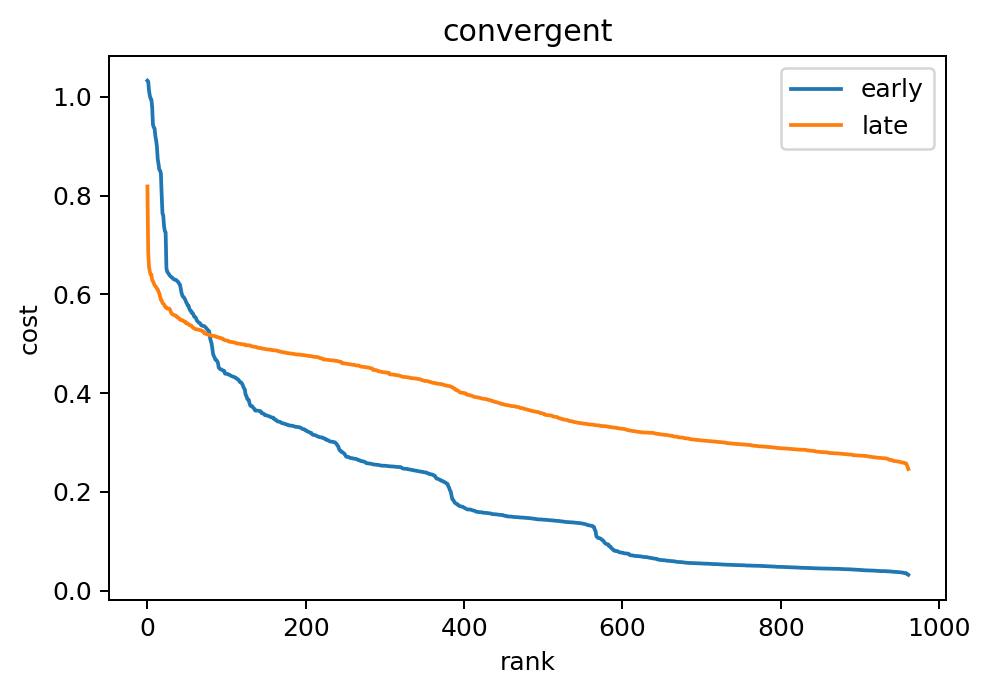

In [20]:
fig, ax = plt.subplots(dpi=180)
ax.plot(ecs, label='early')
ax.plot(lcs, label='late')
ax.set_xlabel("rank")
ax.set_ylabel("cost")
ax.set_title(flow_type)
ax.legend()